# Decision Tree and Random Forest Project
*Name:* Zach Novak

*PID:* za659148

*Date:* 4/6/2025

In this project, you will analyze publicly available loan data from www.LendingClub.com, a platform that connects borrowers (people seeking loans) with investors (people lending money). As an investor, your goal would be to fund loans that have a higher likelihood of being repaid. To assist with this, you will build a predictive model that can classify whether or not a borrower is likely to pay back their loan in full.

You’ll focus on Lending Club’s data from 2007 to 2010, which captures loan activity before the company went public. This dataset provides valuable insights into borrower behavior and loan outcomes, helping you develop a model that can predict repayment success.

For this analysis, you can use the pre-cleaned CSV file provided, which has already been processed to remove missing (NA) values.

Here are what the columns represent:

- credit.policy: 1 if the customer meets the credit underwriting criteria of LendingClub.com, and 0 otherwise.
- purpose: The purpose of the loan (takes values "credit_card", "debt_consolidation", "educational", "major_purchase", "small_business", and "all_other").
- int.rate: The interest rate of the loan, as a proportion (a rate of 11% would be stored as 0.11). Borrowers judged by LendingClub.com to be more risky are assigned higher interest rates.
- installment: The monthly installments owed by the borrower if the loan is funded.
- log.annual.inc: The natural log of the self-reported annual income of the borrower.
- dti: The debt-to-income ratio of the borrower (amount of debt divided by annual income).
- fico: The FICO credit score of the borrower.
- days.with.cr.line: The number of days the borrower has had a credit line.
- revol.bal: The borrower’s revolving balance (amount unpaid at the end of the credit card billing cycle).
- revol.util: The borrower’s revolving line utilization rate (the amount of the credit line used relative to total credit available).
- inq.last.6mths: The borrower’s number of inquiries by creditors in the last 6 months.
- delinq.2yrs: The number of times the borrower had been 30+ days past due on a payment in the past 2 years.
- pub.rec: The borrower’s number of derogatory public records (bankruptcy filings, tax liens, or judgments).

## Import Libraries

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

## Reading the Data & Exploratory Data Analysis & Visualization
Note: The assignment includes a 'no N/A value' data set.

In [2]:
# read in the data
data = pd.read_csv('data/lending_club.csv')

# print data head
print(data.head())

   credit.policy             purpose  int.rate  installment  log.annual.inc  \
0              1  debt_consolidation    0.1189       829.10       11.350407   
1              1         credit_card    0.1071       228.22       11.082143   
2              1  debt_consolidation    0.1357       366.86       10.373491   
3              1  debt_consolidation    0.1008       162.34       11.350407   
4              1         credit_card    0.1426       102.92       11.299732   

     dti  fico  days.with.cr.line  revol.bal  revol.util  inq.last.6mths  \
0  19.48   737        5639.958333      28854        52.1               0   
1  14.29   707        2760.000000      33623        76.7               0   
2  11.63   682        4710.000000       3511        25.6               1   
3   8.10   712        2699.958333      33667        73.2               1   
4  14.97   667        4066.000000       4740        39.5               0   

   delinq.2yrs  pub.rec  not.fully.paid  
0            0        0   

In [3]:
# explore the data
# show the column names, data types, and number of missing values
print(data.info())

# describe the dataframe to get summary statistics
print(data.describe())

# show the unique values in each column
for column in data.columns:
    print(f'{column}: {data[column].unique()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB
None
       credit.policy     int.rate  installment  log.annual

In [4]:
# check for class imbalance (credit.policy target variable)
print(data['credit.policy'].value_counts())

credit.policy
1    7710
0    1868
Name: count, dtype: int64


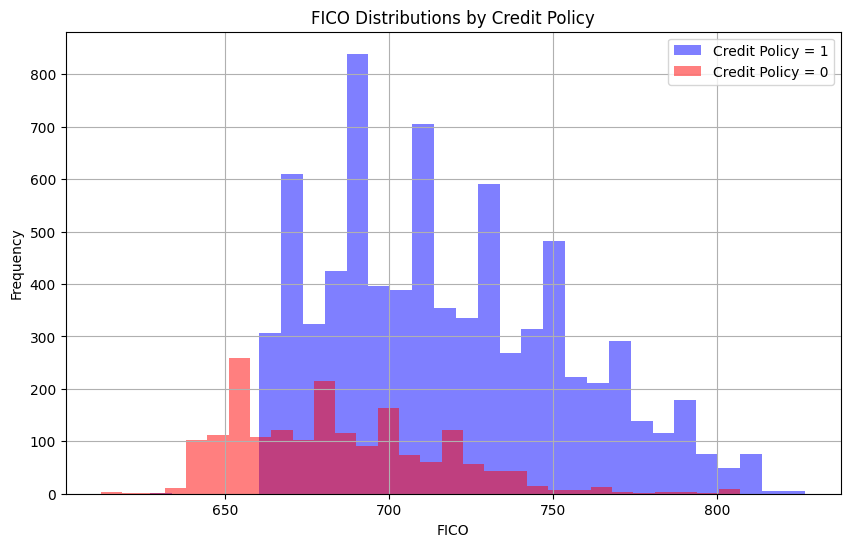

In [5]:
# create a histrogram of two FICO distributions on top of each other, one for each credit.policy outcome.
plt.figure(figsize=(10,6))
data[data['credit.policy'] == 1]['fico'].hist(alpha=0.5, color='blue', bins=30, label='Credit Policy = 1')
data[data['credit.policy'] == 0]['fico'].hist(alpha=0.5, color='red', bins=30, label='Credit Policy = 0')
plt.legend()
plt.xlabel('FICO')
plt.ylabel('Frequency')
plt.title('FICO Distributions by Credit Policy')
plt.show()

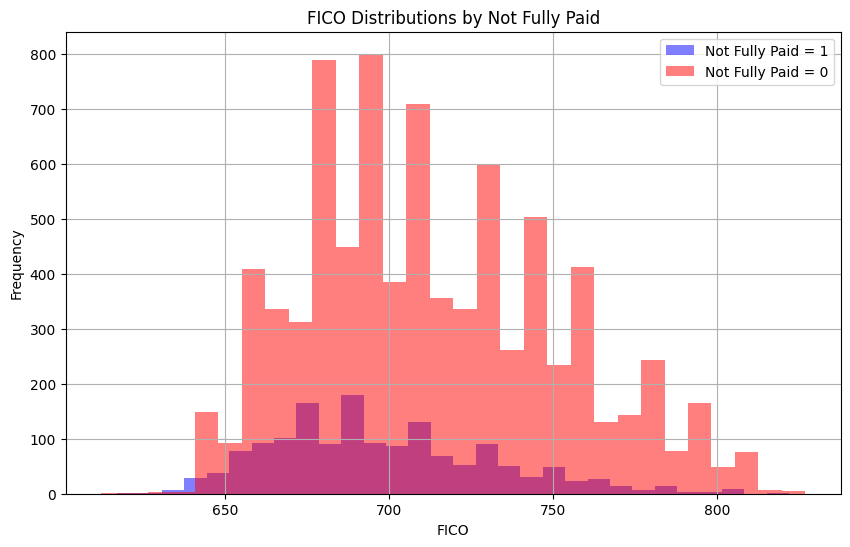

In [6]:
# create a histogram of two FICO distributions on top of each other, one for each not.fully.paid column.
plt.figure(figsize=(10,6))
data[data['not.fully.paid'] == 1]['fico'].hist(alpha=0.5, color='blue', bins=30, label='Not Fully Paid = 1')
data[data['not.fully.paid'] == 0]['fico'].hist(alpha=0.5, color='red', bins=30, label='Not Fully Paid = 0')
plt.legend()
plt.xlabel('FICO')
plt.ylabel('Frequency')
plt.title('FICO Distributions by Not Fully Paid')
plt.show()

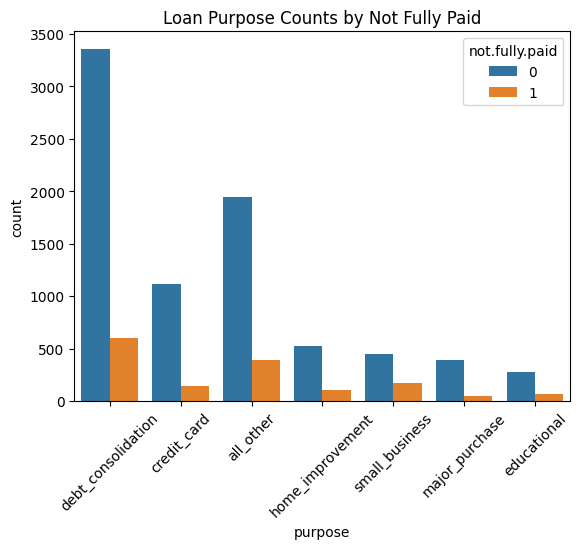

In [7]:
# create a plot using seaborn showing the counts of loans by purpose, with the color hue defined by not.fully.paid.
sns.countplot(x='purpose', hue='not.fully.paid', data=data)
plt.xticks(rotation=45)
plt.title('Loan Purpose Counts by Not Fully Paid')
plt.show()

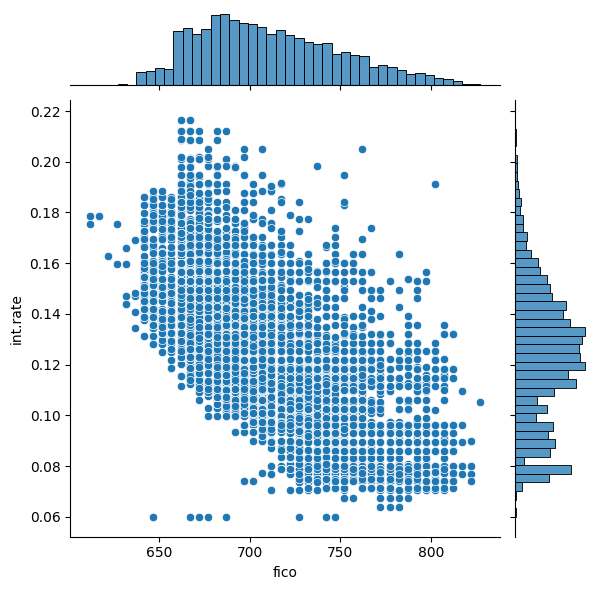

In [8]:
# visualize the trend between FICO score and interest rate. Do this with a joint plot consisting of a scatterplot and histograms.
sns.jointplot(x='fico', y='int.rate', data=data, kind='scatter')
plt.show()

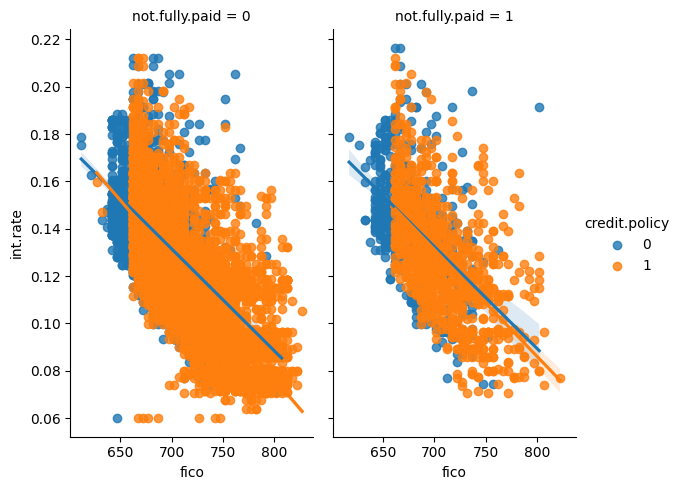

In [9]:
# create the following implots to see if the trend differed between not.fully.paid and credit.policy. 
# check the documentation for Implot() if you can't figure out how to separate it into columns.
sns.lmplot(x='fico', y='int.rate', col='not.fully.paid', hue='credit.policy', data=data, aspect=0.6)

## Setting up the data

### Catergorical Features
Notice that the purpose column is categorical.
That means we need to transform them so sklearn will be able to understand them.
A way of dealing with these columns that can be expanded to multiple categorical features if necessary.

In [10]:
# separate features and target
y = data['not.fully.paid']
X = data.drop('not.fully.paid', axis=1)

# use OneHotEncoder on the 'purpose' column.
categorical_features = ['purpose']
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(drop='first'), categorical_features)],
    remainder='passthrough'
)
X_transformed = preprocessor.fit_transform(X)

### Train Test Split


In [11]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.3, random_state=42)

## Decision Tree Model 
### Training

In [12]:
# create an instance of the Decision Tree Classifier and fit it to the training data.
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)

DecisionTreeClassifier()

### Predictions

In [13]:
# create predictions from the test set.
predictions = dtree.predict(X_test)

### Evaluation

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      2408
           1       0.20      0.21      0.21       466

    accuracy                           0.73      2874
   macro avg       0.52      0.52      0.52      2874
weighted avg       0.74      0.73      0.74      2874



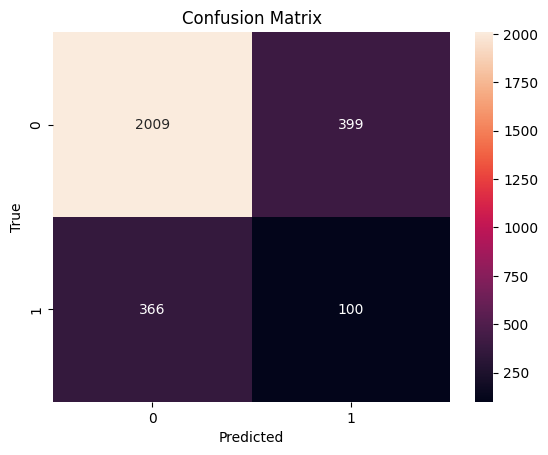

In [14]:
# create a classification report.
print(classification_report(y_test, predictions))

# create and plot a confusion matrix.
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Random Forest Model
### Training

In [15]:
# create an instance of the Random Forest Classifier and fit it to the training data.
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier()

### Predictions

In [16]:
# create predictions on the test set.
rfc_predictions = rfc.predict(X_test)

### Evaluation

              precision    recall  f1-score   support

           0       0.84      0.99      0.91      2408
           1       0.33      0.02      0.03       466

    accuracy                           0.84      2874
   macro avg       0.59      0.51      0.47      2874
weighted avg       0.76      0.84      0.77      2874



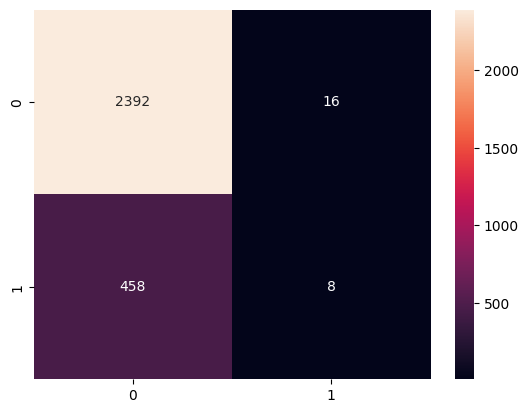

In [17]:
# create a classification report.
print(classification_report(y_test, rfc_predictions))

# create and plot a confusion matrix.
sns.heatmap(confusion_matrix(y_test, rfc_predictions), annot=True, fmt='d')
plt.show()

## Which performed better?
The Random Forest or the Decision Tree?

The decision tree model had an accuracy of 72% which is a moderate performance, however, the random forest model improved accuracy up to 83% showing it is better in this scenario. However, both models had challenges in predicting the minority class 'not fully paid loans' shwon by the low precision and recall scores. As mentioned in the DT_RF.pdf file, there is a known class imbalance which makes the minority class performance not surprising. This can be improved with balancing techniques like resampling or sythetic injection. Given that the business objective centers around accurately predicting loan defaults to mitigate financial risk, addressing this imbalance is crucial. Neglecting this issue could leave the bank vulnerable to increased customer default risk.